# CFG sampling and plotting

**Description:** Sampling from the trained Flow model using Euler integration, decoding via AE, and plotting UMAPs.

In [1]:
import os
import sys
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scvi.distributions import NegativeBinomial


sys.path.append("../../")
from utils.autoencoder_utils import NB_Autoencoder
from utils.classifier_free_guidance import *

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Configuration & Data Stats
We load the data here primarily to recover cell type mappings and library size statistics for sampling.

In [2]:
input_file_path = "/dtu/blackhole/06/213542/paperdata/pbmc3k_train_with_latent.h5ad"
ae_model_path = "/dtu/blackhole/06/213542/paperdata/pbmc3k_train_nb_autoencoder.pt"
flow_model_save_path = "/dtu/blackhole/06/213542/paperdata/lib_size_flow_model.pt"

# Sampling Hyperparameters
guidance_scale = 2.0
n_steps = 50 
latent_dim = 50

# Load Data for Reference
adata = ad.read_h5ad(input_file_path)
latent = adata.obsm["X_latent"]
latent_tensor = torch.tensor(latent, dtype=torch.float32, device=device)

# Library Stats
if "total_counts" in adata.obs:
    lib_sizes = adata.obs["total_counts"].values
else:
    lib_sizes = np.array(adata.X.sum(1)).flatten()

log_lib_sizes = np.log1p(lib_sizes)
log_lib_tensor = torch.tensor(log_lib_sizes, dtype=torch.float32, device=device).unsqueeze(1)
lib_mean, lib_std = log_lib_tensor.mean(), log_lib_tensor.std()

# Cell Type Mappings
cell_types = adata.obs["cell_type"].astype(str).values
unique_types, inverse_idx = np.unique(cell_types, return_inverse=True)
num_cell_types = len(unique_types)

print(f"Loaded metadata. {num_cell_types} cell types found.")

Loaded metadata. 8 cell types found.


## Load Models

In [ ]:
# 1. Initialize and Load Flow Model
conditioner = CellTypeConditioner(n_types=num_cell_types, latent_dim=latent_dim).to(device)
vf_model = NeuralVectorField(latent_dim=latent_dim).to(device)

checkpoint = torch.load(flow_model_save_path, map_location=device)
vf_model.load_state_dict(checkpoint['vf_state'])
conditioner.load_state_dict(checkpoint['cond_state'])
print("Flow model loaded.")


ae = NB_Autoencoder(num_features=adata.n_vars, latent_dim=latent_dim)
try:
    ae.load_state_dict(torch.load(ae_model_path, map_location=device))
    ae.to(device)
    ae.eval()
    print("AE loaded successfully.")
except FileNotFoundError:
    print(f"Warning: AE model not found at {ae_model_path}. Decoding will fail.")

Flow model loaded.
AE loaded successfully.


## Sampling & Decoding
If we want specific cell type


In [9]:
def generate_full_dataset(n_per_type=200):
    """
    Generates samples for all cell types to create a full synthetic dataset.
    """
    vf_model.eval()
    conditioner.eval()
    
    all_latents = []
    all_lib_sizes = []
    all_types = []
    
    print(f"Generating {n_per_type} cells per type for {len(unique_types)} types...")
    for idx, ct in enumerate(unique_types):
        # Conditions
        type_tensor = torch.full((n_per_type,), idx, dtype=torch.long, device=device)
        l_tensor = torch.normal(lib_mean.item(), lib_std.item(), (n_per_type, 1), device=device)
        
        # Initial Noise
        x = torch.randn(n_per_type, latent_dim, device=device)
        
        # Integration
        ode = LearnedVectorFieldODE(vf_model, conditioner, type_tensor, l_tensor, guidance_scale=10.0)
        dt = 1.0 / n_steps
        t = torch.zeros(n_per_type, 1, device=device)
        
        with torch.no_grad():
            for _ in range(n_steps):
                v = ode.drift(x, t)
                x = x + v * dt
                t = t + dt
        
        all_latents.append(x)
        all_lib_sizes.append(l_tensor)
        all_types.extend([ct] * n_per_type)
        
    gen_latents_tensor = torch.cat(all_latents, dim=0)
    gen_libs_tensor = torch.cat(all_lib_sizes, dim=0)
    
    # Rescaling
    mean_gen = gen_latents_tensor.mean(dim=0)
    std_gen = gen_latents_tensor.std(dim=0)
    mean_orig = latent_tensor.mean(dim=0)
    std_orig = latent_tensor.std(dim=0)
    
    gen_rescaled = (gen_latents_tensor - mean_gen) / std_gen * std_orig + mean_orig
    
    # Decode to Counts
    lib_counts = torch.exp(gen_libs_tensor) - 1
    
    print("Decoding full dataset...")
    with torch.no_grad():
        outputs = ae.decode(gen_rescaled, adata, lib_counts)
        mu = outputs["mu"]
        theta = torch.exp(outputs["theta"])
        nb_dist = NegativeBinomial(mu=mu, theta=theta)
        X_counts = nb_dist.sample().cpu().numpy()
        
    return X_counts, np.array(all_types)

# Generate and Save
X_gen_all, types_gen_all = generate_full_dataset(n_per_type=250)

adata_gen = ad.AnnData(X=X_gen_all)
adata_gen.obs['cell_type'] = types_gen_all
adata_gen.obs['dataset'] = 'Generated'
adata_gen.var_names = adata.var_names

save_gen_path = os.path.join(os.path.dirname(flow_model_save_path), "generated_cells.h5ad")
adata_gen.write(save_gen_path)
print(f"Saved all generated cells to: {save_gen_path}")

Generating 250 cells per type for 8 types...
Decoding full dataset...
Decoding full dataset...
Saved all generated cells to: /dtu/blackhole/06/213542/paperdata/generated_cells.h5ad
Saved all generated cells to: /dtu/blackhole/06/213542/paperdata/generated_cells.h5ad


## Plotting Results

Running PCA and UMAP on merged dataset...

--- Starting Visualization Generation ---

--- Starting Visualization Generation ---


/work3/s243171/venv_1/lib/python3.11/site-packages/anndata/_core/anndata.py:1176: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/work3/s243171/venv_1/lib/python3.11/site-packages/anndata/_core/anndata.py:1176: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


Figure saved to /dtu/blackhole/06/213542/paperdata/cfgen_results_figure_a2.png


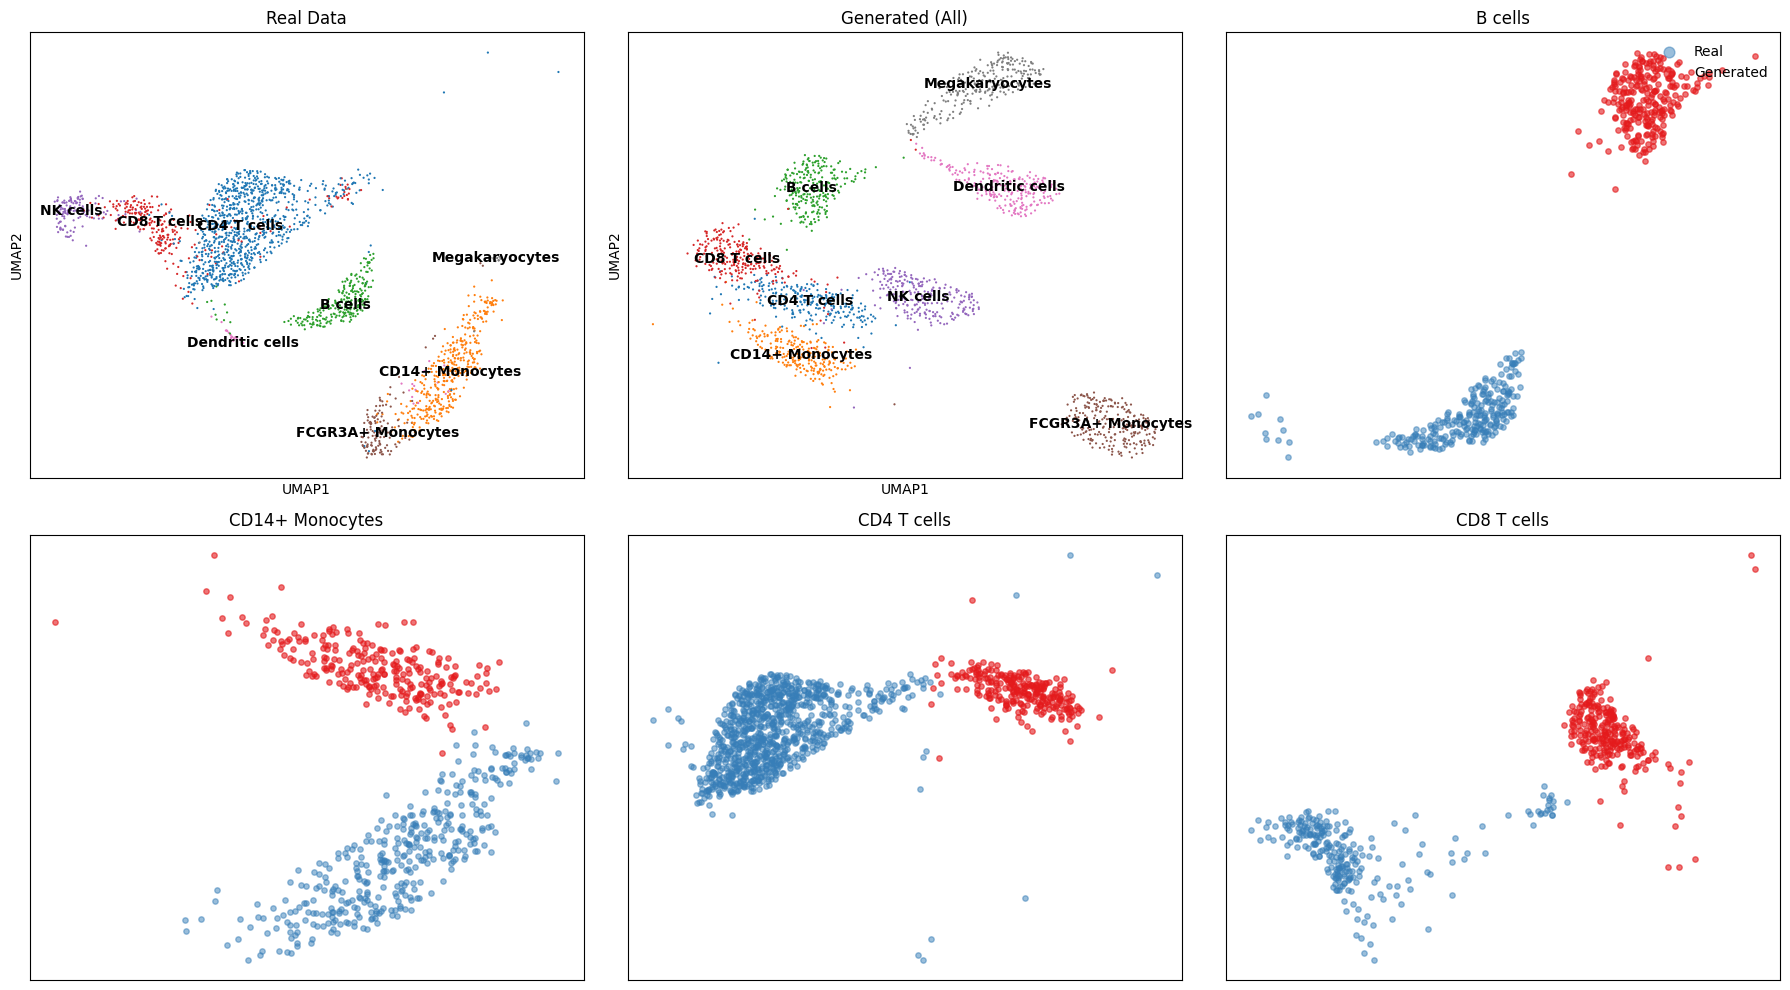

In [10]:
# Prepare Merged Dataset
adata_real = adata.copy()
adata_real.obs['dataset'] = 'Real'
if hasattr(adata_real.X, "toarray"):
    adata_real.X = adata_real.X.toarray()

adata_merged = ad.concat([adata_real, adata_gen], join='outer', label='batch', keys=['Real', 'Generated'])
adata_merged.obs['cell_type'] = adata_merged.obs['cell_type'].astype('category')

# Preprocessing & Embedding
print("Running PCA and UMAP on merged dataset...")
sc.pp.normalize_total(adata_merged, target_sum=1e4)
sc.pp.log1p(adata_merged)
sc.pp.pca(adata_merged, n_comps=30)
sc.pp.neighbors(adata_merged, n_neighbors=15)
sc.tl.umap(adata_merged)

# Visualization
print("\n--- Starting Visualization Generation ---")
highlight_types = ['B cells', 'CD14+ Monocytes', 'CD4 T cells', 'CD8 T cells']

fig = plt.figure(figsize=(18, 10))
gs = gridspec.GridSpec(2, 3, figure=fig)

# Panel 1: Real Data
ax1 = fig.add_subplot(gs[0, 0])
plot_umap_scatter(ax1, adata_merged[adata_merged.obs['dataset']=='Real'], 
                  'cell_type', 'Real Data')

# Panel 2: Generated Data
ax2 = fig.add_subplot(gs[0, 1])
plot_umap_scatter(ax2, adata_merged[adata_merged.obs['dataset']=='Generated'], 
                  'cell_type', 'Generated (All)')

# Overlap Panels
locs = [(0, 2), (1, 0), (1, 1), (1, 2)]
for i, c_type in enumerate(highlight_types):
    if i >= len(locs): break
    ax = fig.add_subplot(gs[locs[i]])
    plot_overlap(ax, c_type, adata_merged)
    if i == 0:
        ax.legend(frameon=False, loc='upper right', markerscale=2)

plt.tight_layout()
save_plot_path = os.path.join(os.path.dirname(flow_model_save_path), "cfgen_results_figure_a2.png")
plt.savefig(save_plot_path, dpi=300)
print(f"Figure saved to {save_plot_path}")
plt.show()